# Time-Resolved Difference Map 

Time-resolved crystallography experiments make use of X-ray diffraction to monitor structural changes in a crystalline sample. Such experiments typically use a pump-probe setup where atomic motions are induced by a "pump" (often some sort of a laser pulse) and then are monitored using a probe X-ray pulse. Due to the need for an X-ray pulse with a short time duration, it is most common to conduct time-resolved diffraction experiments using an XFEL or using a Laue (pink beam) beamline at a synchrotron in order to achieve the desired X-ray intensity.  

A common methodology for investigating structural changes in time-resolved experiments is using difference maps between structure factor amplitudes collected with and without a perturbation. These $(|F_{On}| - |F_{Off}|)$ maps may be noisy due to systematic errors or scaling artifacts, and have historically been weighted based on the magnitude of the difference signal and/or the error estimates associated with the measured values. 

Photoactive yellow protein (PYP) is a model system in time-resolved crystallography due to the trans-cis isomerization of its chromophore which occurs upon absorption of blue light. Here, we will use `reciprocalspaceship` to produce a weighted difference map of PYP to investigate the structural changes that occur 2ms after illumination with blue light. This dataset was collected at the [BioCARS Laue beamline APS-14-ID](https://biocars.uchicago.edu/) from a PYP crystal with $P 6_3$ symmetry, and were processed using Precognition (Renz Research, Inc.), a software suite for Laue data processing. This data was collected and provided by Marius Schmidt and Vukica Šrajer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import numpy as np

In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

0.8.9


---
### Load `On` and `Off` PYP DataSets  

The `.hkl` files used in this example came directly from Precognition and contain scaled, merged structure amplitudes (**F**) and associated errors (**SigF**). Precognition uses a different convention for the reciprocal space asymmetric unit (ASU) than CCP4/Phenix, so we will map all reflections to the ASU. 

In [4]:
def load(hkl, cell=(66.9, 66.9, 40.8, 90.0, 90.0, 120.0), sg=173):
    """
    Load HKL file from Precognition and map reflections to the reciprocal space ASU.
    """
    dataset = rs.read_precognition(hkl, *cell, sg=sg)
    dataset.hkl_to_asu(inplace=True)
    dataset.drop(columns="M/ISYM", inplace=True)
    return dataset

In [5]:
off = load("data/PYP_varEll_2sig_off_1.6A.hkl")
on  = load("data/PYP_varEll_2sig_2ms_1.6A.hkl")

Since difference maps can only be made with Fourier magnitudes that were measured in both datasets, we will subset the datasets to their common Miller indices.

In [6]:
pyp = off.merge(on, left_index=True, right_index=True, suffixes=("_off", "_on"))

In [7]:
pyp.head()

F_off  SigF_off    F_on  SigF_on
H K L                                   
0 1 2  56.646     0.036  75.991    0.032
    3  89.061      0.03  89.667    0.031
    4  95.419     0.048  93.886    0.047
    5 160.466     0.038 162.553    0.035
    6  77.869     0.075  79.139    0.083

---
### Compute Difference Map Coefficients and Errors  

We will compute $(|F_{On}| - |F_{Off}|)$ for use as the coefficients of the difference map, and we will propagate the uncertainties in quadrature. These propagated uncertainties will be used when computing weights for each Miller index.

In [8]:
pyp["DF"] = (pyp["F_on"] - pyp["F_off"]).astype("SFAmplitude")
pyp["SigDF"] = np.sqrt(pyp["SigF_on"]**2 + pyp["SigF_off"]**2).astype("Stddev")

---
### Compute Difference Map Weights  

There are several weighting schemes that have been used to produce time-resolved difference maps. Many of them take the form below, involving a term based on the uncertainty in the difference structure factor amplitude ($\sigma_{\Delta F}$), and optionally, a scale term based on the the magnitude of the observed $\Delta F$. With $\alpha=0$, these weights take the form employed in [Ursby and Bourgeois, **Acta Cryst** (1997)](https://scripts.iucr.org/cgi-bin/paper?he0183). On the other hand, [Šrajer *et al*, **Biochemistry** (2001)](https://pubs.acs.org/doi/10.1021/bi010715u) employed weights with $\alpha=1$ in order to decrease the impact of abnormally large values of $\Delta F$ that may have erroneously small uncertainties. Finally, other weighting schemes have employed intermediate values of $\alpha$ ([Hekstra *et al*, **Nature** (2016)](https://www.nature.com/articles/nature20571)). 

\begin{equation}
w = \left(1 + \frac{\sigma_{\Delta F}^2}{\langle \sigma_{\Delta F}^2 \rangle} + \alpha\frac{|\Delta F|^2}{\langle |\Delta F|^2 \rangle} \right)^{-1}
\end{equation}  

For illustration purposes, we will compute weights with $\alpha=0.05$.

In [9]:
def compute_weights(df, sigdf, alpha=0):
    """
    Compute weights for each structure factor based on deltaF and its uncertainty
    """
    w = (1 + (sigdf**2 / (sigdf**2).mean()) + alpha*(df**2 / (df**2).mean()))
    return w**-1

In [10]:
pyp["W"] = compute_weights(pyp["DF"], pyp["SigDF"], alpha=0.05)
pyp["WDF"] = (pyp["W"]*pyp["DF"]).astype("F")

Let's visualize the weights relative to the magnitude of $\Delta F$ and the signal-to-noise ratio in order to understand how they will affect different structure factors.

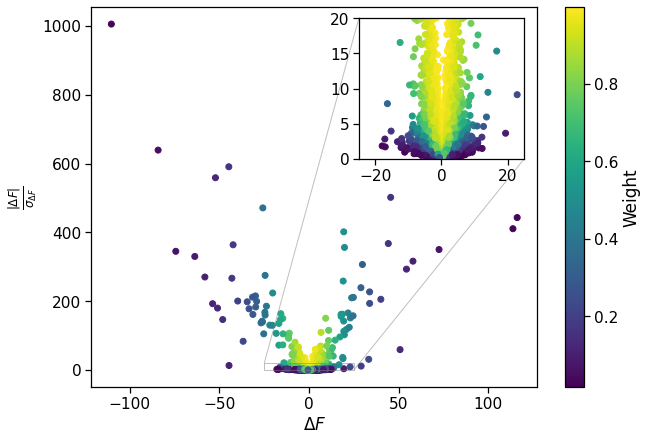

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
pts = ax.scatter(pyp.DF, pyp.DF.abs()/pyp.SigDF, c=pyp.W)
ax.set_xlabel(r"$\Delta F$")
ax.set_ylabel(r"$\frac{\left| \Delta F \right|}{\sigma_{\Delta F}}$")

# Inset
axins = ax.inset_axes([0.6, 0.6, 0.37, 0.37])
axins.scatter(pyp.DF, pyp.DF.abs()/pyp.SigDF, c=pyp.W)
x1, x2, y1, y2 = -25, 25, 0, 20
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)

fig.colorbar(pts, label="Weight")
plt.show()

As seen in the above plot, difference Fourier coefficients with low signal-to-noise ratios (large $\sigma_{\Delta F}$ relative to $|\Delta F|$) are assigned lower weight. Difference Fourier coefficients with large amplitude are also assigned lower weight.

---
### Visualize Weighted Difference Map  

We have our difference Fourier amplitudes and weights, so we just need phases in order to make a difference map. We will use phases from a refined "dark" state model of PYP, PDB: 2PHY. Phases were computed using [phenix.fmodel](https://www.phenix-online.org/documentation/reference/fmodel.html).  

In [12]:
ref = rs.read_mtz("data/2PHY.pdb.mtz")
pyp["PHIFMODEL"] = ref.loc[pyp.index, "PHIFMODEL"]
pyp.write_mtz("data/PYP_diffmap.mtz")

Let's now visualize the effects of weighting the $(F_{On} - F_{Off})$ difference map. The map is overlaid with the refined model of the dark state (red; PDB: 2PHY) and the pB intermediate state of the chromophore (green; PDB: 3UME).

In [13]:
%%html
<center>
    <iframe src="https://hekstra-lab.github.io/reciprocalspaceship/data/pypdiff/comparison.html#xyz=14.870,0.383,-18.885&eye=85.6,69.5,-33.7&zoom=60", width=600, height=300></iframe>
    <br>Time-resolved difference map of PYP photocycle with and without weights. The dark state structure is shown in 
</center>